In [ ]:
# chat gpt

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

from pathlib import Path

In [3]:
#path_cig = Path("/content/drive/MyDrive/dymid_data/VB_ Data/conference_export_202305212127.csv")

path_cig= Path("/content/drive/MyDrive/cigar/Cigars_export_202303071027.csv")

df = pd.read_csv(path_cig,parse_dates=[0], infer_datetime_format=True)

futura_val = pd.read_csv("/content/drive/MyDrive/dymid_data/Cigars_export_202306291127.csv")

In [4]:
df.tail()

,Timestamp,Temperature_Celsius,Relative_Humidity
18245,2023-03-07 09:27:00,20.8,65.9
18246,2023-03-07 09:42:00,20.9,65.6
18247,2023-03-07 09:57:00,20.8,65.4
18248,2023-03-07 10:12:00,20.8,65.4
18249,2023-03-07 10:27:00,21.0,66.0


In [5]:
df.drop('Temperature_Celsius', axis=1, inplace=True)

In [6]:

df.head()

,Timestamp,Relative_Humidity
0,2022-08-29 07:42:00,67.0
1,2022-08-29 07:57:00,67.7
2,2022-08-29 08:12:00,68.2
3,2022-08-29 08:27:00,68.5
4,2022-08-29 08:42:00,68.7


In [7]:
df_copy=df.copy()

In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df=df.set_index(['Timestamp'])

In [9]:
data=df.copy()

In [10]:

futura_val.head()

,Timestamp,Temperature_Celsius,Relative_Humidity
0,2022-08-29 17:42:00,22.4,67.0
1,2022-08-29 17:57:00,22.4,67.7
2,2022-08-29 18:12:00,22.4,68.2
3,2022-08-29 18:27:00,22.5,68.5
4,2022-08-29 18:42:00,22.5,68.7


<Axes: xlabel='Timestamp'>

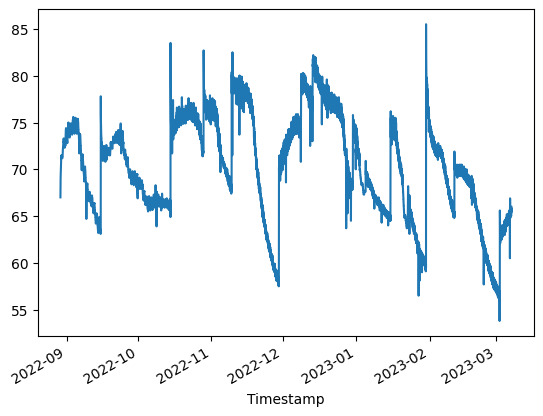

In [11]:
df['Relative_Humidity'].plot()

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [13]:
# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [14]:
print(scaled_data.shape)

(18250, 1)


In [15]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [16]:
print(train_data.shape)
print(test_data.shape)

(14600, 1)
(3650, 1)


In [17]:
# Create input and output sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [18]:

seq_length = 60  # Number of previous time steps to use as input

In [19]:
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [20]:

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences = True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32)#

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [ ]:
savedModel=model

In [ ]:
#model.save('/content/drive/MyDrive/dymid_data/exp14(cigar)_50_seq100.h5')
#print('Model Saved!')

In [24]:
savedModel=load_model('/content/drive/MyDrive/dymid_data/exp14(cigar)_50.h5')

In [25]:
# Generate predictions for train, test, and future data
y_train_pred = savedModel.predict(X_train)
y_test_pred = savedModel.predict(X_test)

113/113 [==============================] - 1s 11ms/step


In [26]:

# Use the last `seq_length` data points from the test set as the initial input for future prediction
last_sequence = X_test[-1]


In [27]:

# Generate predictions for the future data
future_pred = []
for _ in range(96):
    # Reshape the input data to match the model's input shape
    last_sequence = last_sequence.reshape((1, seq_length, 1))

    # Predict the next value
    next_value = savedModel.predict(last_sequence)

    # Append the predicted value to the result array
    future_pred.append(next_value[0][0])

    # Update the last sequence with the predicted value
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_value


1/1 [==============================] - 0s 35ms/step


In [28]:
# Scale the predictions back to the original range
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
future_pred = scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

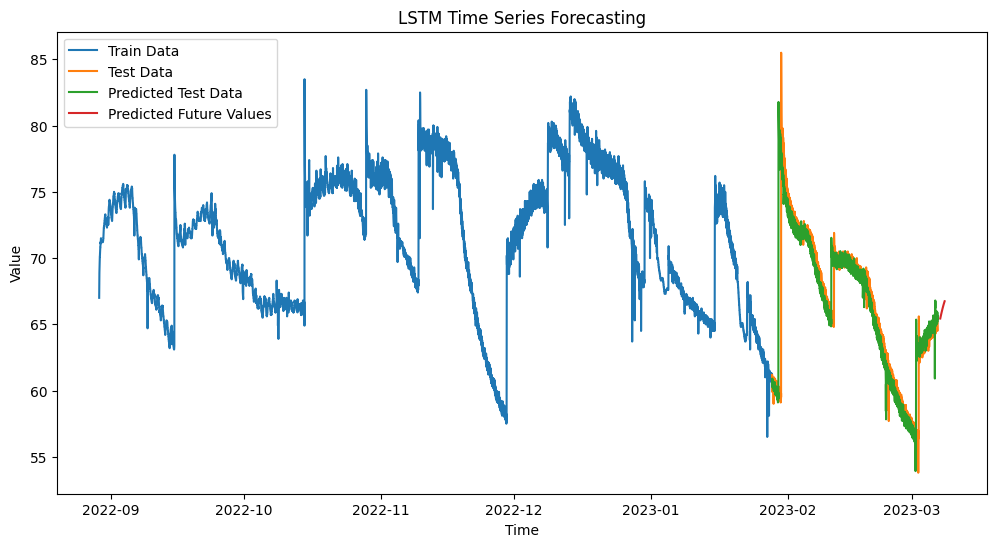

In [29]:
# Plot the original data, predicted train values, predicted test values, and predicted future values
# Create an array of timestamps for the predicted values
timestamps = pd.date_range(start=data.index[-1], periods=96, freq='15min')

plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], data.values[:train_size], label='Train Data')
plt.plot(data.index[train_size:train_size+len(y_test_pred)], data.values[train_size:train_size+len(y_test_pred)], label='Test Data')
plt.plot(data.index[train_size:train_size+len(y_test_pred)], y_test_pred, label='Predicted Test Data')
plt.plot(timestamps, future_pred, label='Predicted Future Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Time Series Forecasting')
plt.legend()
plt.show()

In [30]:
# Scale the predictions and ground truth back to the original range
y_pred = y_test_pred
y_test = scaler.inverse_transform(y_test)

In [31]:
# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', rmse)

Test RMSE: 0.541026960991567


In [32]:
# Scale the predictions and ground truth back to the original range
y_pred = y_train_pred
y_test = scaler.inverse_transform(y_train)

In [33]:
# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Train RMSE:', rmse)

Train RMSE: 0.416341747235169


In [34]:
df_copy.tail(1)

,Timestamp,Relative_Humidity
18249,2023-03-07 10:27:00,66.0


In [35]:
timestamps

DatetimeIndex(['2023-03-07 10:27:00', '2023-03-07 10:42:00',
               '2023-03-07 10:57:00', '2023-03-07 11:12:00',
               '2023-03-07 11:27:00', '2023-03-07 11:42:00',
               '2023-03-07 11:57:00', '2023-03-07 12:12:00',
               '2023-03-07 12:27:00', '2023-03-07 12:42:00',
               '2023-03-07 12:57:00', '2023-03-07 13:12:00',
               '2023-03-07 13:27:00', '2023-03-07 13:42:00',
               '2023-03-07 13:57:00', '2023-03-07 14:12:00',
               '2023-03-07 14:27:00', '2023-03-07 14:42:00',
               '2023-03-07 14:57:00', '2023-03-07 15:12:00',
               '2023-03-07 15:27:00', '2023-03-07 15:42:00',
               '2023-03-07 15:57:00', '2023-03-07 16:12:00',
               '2023-03-07 16:27:00', '2023-03-07 16:42:00',
               '2023-03-07 16:57:00', '2023-03-07 17:12:00',
               '2023-03-07 17:27:00', '2023-03-07 17:42:00',
               '2023-03-07 17:57:00', '2023-03-07 18:12:00',
               '2023-03-

In [36]:
future_pred

array([[65.43838 ],
       [65.45463 ],
       [65.47085 ],
       [65.48702 ],
       [65.50317 ],
       [65.51927 ],
       [65.53533 ],
       [65.55136 ],
       [65.567345],
       [65.58329 ],
       [65.59919 ],
       [65.61505 ],
       [65.63087 ],
       [65.646645],
       [65.66237 ],
       [65.678055],
       [65.693695],
       [65.70928 ],
       [65.72483 ],
       [65.74033 ],
       [65.755775],
       [65.77118 ],
       [65.78652 ],
       [65.80183 ],
       [65.81707 ],
       [65.83226 ],
       [65.847404],
       [65.86249 ],
       [65.87753 ],
       [65.89251 ],
       [65.90744 ],
       [65.92231 ],
       [65.93713 ],
       [65.95189 ],
       [65.96659 ],
       [65.98124 ],
       [65.99583 ],
       [66.01036 ],
       [66.02483 ],
       [66.039246],
       [66.0536  ],
       [66.06789 ],
       [66.08212 ],
       [66.09629 ],
       [66.110405],
       [66.12445 ],
       [66.13844 ],
       [66.152374],
       [66.16623 ],
       [66.18003 ],


In [37]:
futura_val .head()

,Timestamp,Temperature_Celsius,Relative_Humidity
0,2022-08-29 17:42:00,22.4,67.0
1,2022-08-29 17:57:00,22.4,67.7
2,2022-08-29 18:12:00,22.4,68.2
3,2022-08-29 18:27:00,22.5,68.5
4,2022-08-29 18:42:00,22.5,68.7


In [38]:
start_date = '2023-03-07 10:27:00'
end_date   = '2023-03-08 10:12:00'
filter_df = futura_val.query('Timestamp >= @start_date and Timestamp <= @end_date')

In [39]:
filter_df.shape

(96, 3)

In [40]:
filter_df

,Timestamp,Temperature_Celsius,Relative_Humidity
18209,2023-03-07 10:27:00,20.8,65.8
18210,2023-03-07 10:42:00,20.8,65.5
18211,2023-03-07 10:57:00,20.8,65.2
18212,2023-03-07 11:12:00,20.6,65.0
18213,2023-03-07 11:27:00,20.6,65.4
...,...,...,...
18300,2023-03-08 09:12:00,20.5,65.8
18301,2023-03-08 09:27:00,20.5,65.5
18302,2023-03-08 09:42:00,20.5,65.4
18303,2023-03-08 09:57:00,20.6,66.1


In [41]:
filter_df['pred'] = future_pred.tolist()
filter_df = filter_df.astype({'pred':'string'})
filter_df["pred"]=filter_df["pred"].str[1:-1]
filter_df['pred'] = filter_df['pred'].astype(float)

In [42]:
filter_df

,Timestamp,Temperature_Celsius,Relative_Humidity,pred
18209,2023-03-07 10:27:00,20.8,65.8,65.438377
18210,2023-03-07 10:42:00,20.8,65.5,65.454628
18211,2023-03-07 10:57:00,20.8,65.2,65.470848
18212,2023-03-07 11:12:00,20.6,65.0,65.487022
18213,2023-03-07 11:27:00,20.6,65.4,65.503166
...,...,...,...,...
18300,2023-03-08 09:12:00,20.5,65.8,66.699715
18301,2023-03-08 09:27:00,20.5,65.5,66.710617
18302,2023-03-08 09:42:00,20.5,65.4,66.721458
18303,2023-03-08 09:57:00,20.6,66.1,66.732224


In [ ]:
filter_df=filter_df.set_index(['Timestamp'])

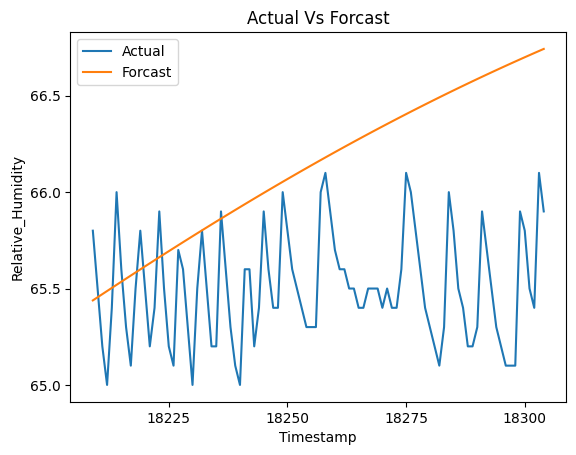

In [43]:
from matplotlib import pyplot

# plot
pyplot.plot(filter_df['Relative_Humidity'], label = 'Actual')
pyplot.plot(filter_df['pred'], label = 'Forcast')
pyplot.title("Actual Vs Forcast")
pyplot.xlabel('Timestamp')
pyplot.ylabel('Relative_Humidity')
pyplot.legend()
# changing the rc parameters and plotting a line plot
pyplot.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 20
pyplot.show()